In [3]:
import pandas as pd
import sklearn
import os
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
#import torch

pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
data_folder = '/Users/mkamruz/Public/SNL/Projects/5UTR/Data/seq_data/'
pred_folder = '/Users/mkamruz/Public/SNL/Projects/5UTR/Data/All_predictions/'

In [8]:
def compute_hard_voting_threshold(df, valid_labels):
    _,_, thresholds = sklearn.metrics.roc_curve(valid_labels, df.iloc[:, 0].values.tolist())


def compute_metric(valid_labels, valid_predictions):
    cm = sklearn.metrics.confusion_matrix(valid_labels, valid_predictions)
    # The .ravel() method flattens the 2D matrix into a 1D array
    tn, fp, fn, tp = cm.ravel()
    recall = sklearn.metrics.recall_score(
            valid_labels, valid_predictions, average="macro", zero_division=0
        )
    tnr = tn / (tn+fp) if (tn+fp)>0 else 0
    fpr = fp / (fp+tn) if (tn+fp)>0 else 0
    tpr = tp / (tp + fn) if (tp + fn)>0 else 0
    
    return {
        "accuracy": sklearn.metrics.accuracy_score(valid_labels, valid_predictions),
        "f1": sklearn.metrics.f1_score(
            valid_labels, valid_predictions, average="macro", zero_division=0
        ),
        "precision": sklearn.metrics.precision_score(
            valid_labels, valid_predictions, average="macro", zero_division=0
        ),
        "recall": recall,
        "TNR": tnr,
        "FPR": fpr,
        "TPR": tpr
    }

def calculate_metric_with_sklearn(valid_proba, valid_labels, model, tr, ts, threshold=0.5):
    """
    Manually calculate the accuracy, f1, matthews_correlation, precision, recall with sklearn.
    """
    valid_predictions = (np.array(valid_proba)>=threshold).astype(int)
    perf = compute_metric(valid_labels, valid_predictions)
    auc = sklearn.metrics.roc_auc_score(valid_labels, valid_proba)
    
    return {
        "model":model,
        "train_on":tr,
        "test_on":ts,
        "accuracy": perf['accuracy'],
        "f1": perf['f1'],
        "precision": perf['precision'],
        "recall": perf['recall'],
        "TNR": perf['TNR'],
        "auc":auc
    }

def calculate_metric_for_majority_vote(valid_labels, valid_predictions, model, tr, ts):
    """
    Manually calculate the accuracy, f1, matthews_correlation, precision, recall with sklearn.
    """
    perf = compute_metric(valid_labels, valid_predictions)
    return {
        "model":model,
        "train_on":tr,
        "test_on":ts,
        "accuracy": perf['accuracy'],
        "f1": perf['f1'],
        "precision": perf['precision'],
        "recall": perf['recall'],
        "TNR": perf['TNR'],
        'auc': 0.0
    }

def compute_hard_vote(df, valid_labels, verbose=0):
    cSum = df.sum(axis=1).values.tolist()
    if verbose: print(cSum)
    tc = [df.shape[1]]*len(cSum)
    if verbose: print(tc)
    if verbose: print(valid_labels)

    def get_vote(a,b,c):
        odd = b%2
        b = b//2
        
        if a>b: return int(1)
        elif a==b:
            if odd==0: return int(c)

        return int(0)

    vote = [get_vote(a,b,c) for a,b,c in zip(cSum, tc, valid_labels)]
    if verbose: print(vote)
    if verbose: print(sum(vote), sum(valid_labels))
    return vote

def compute_threshold_pred(df, valid_labels, verbose=0):
    #df['mean_scores'] = df.mean(axis=1).values.tolist()
    #df['true_label'] = valid_labels

    mean_scores = df.mean(axis=1).values.tolist()
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(valid_labels, mean_scores)

    return tpr, fpr, thresholds, mean_scores
    

## Mode (Majority or Hard vote)

In [9]:
perf = []
for p in ['mpra_data', 'cao2021/ratios/hek', 'cao2021/ratios/hek_muscle', 
              'cao2021/ratios/hek_muscle_pc3', 'cao2021/ratios/hek_pc3', 'cao2021/ratios/muscle', 
              'cao2021/ratios/muscle_pc3', 'cao2021/ratios/pc3']:
    
    print(f"For test data [{p}]...")
    test_data = pd.read_csv(os.path.join(data_folder, p, 'test.csv'), delimiter=',', skiprows=1, header=None)
    if test_data.shape[1] == 2:
        labels = test_data[1].values.flatten()
    elif test_data.shape[1] > 2:
        labels = test_data[2].values.flatten()
    
    del [test_data]

    test_on = p.split('/')[-1]

    df_pred = None
    df_proba = None
    pred_cols = []
    proba_cols = []

    for mName in ['DNABERT2', 'UTRLM', 'GROVER']:
        #perf[tr][mName]={}

        pred_data = pd.read_csv(os.path.join(pred_folder, f"{mName}_test_{test_on}_results_sep.csv"))
        pred_data.drop(columns=['cao2021', 'cao2021_proba'], inplace=True)

        pred_col = [col for col in pred_data.columns if 'proba' not in col]
        proba_col = [col for col in pred_data.columns if 'proba' in col]
        
        df_pred_data = pred_data[pred_col]
        df_proba_data = pred_data[proba_col]

        for col in df_pred_data.columns:
            pred_cols.append(f"{mName}_{col}")                                                                                                                      
            df_pred_data[col] = df_pred_data[col].astype(int)

        for col in df_proba_data.columns:
            proba_cols.append(f"{mName}_{col}")

        #print(mName, pred_data.shape)
        #display(pred_data.head())

        if df_pred is None:
            df_pred = pd.DataFrame(df_pred_data)
        else:
            df_pred = pd.concat([df_pred, df_pred_data], ignore_index=True, axis=1)

        del [df_pred_data]

        if df_proba is None:
            df_proba = pd.DataFrame(df_proba_data)
        else:
            df_proba = pd.concat([df_proba, df_proba_data], ignore_index=True, axis=1)

        del [df_proba_data]

    df_pred.columns = pred_cols
    df_proba.columns = proba_cols
    #display(df.head())
    
    valid_labels = labels if df_pred.shape[0]==len(labels) else labels[1:]
    df_pred[f'Major_vote'] = compute_hard_vote(df_pred, valid_labels)

    perf.append(calculate_metric_for_majority_vote(df_pred['Major_vote'].values.tolist(), valid_labels, 'Major_vote', '-', test_on))
        
    #display(df_proba.head())
    for col in df_proba.columns:
            k = col
            model = k.split('_')[0]
            k = '_'.join(k.split('_')[1:])
            if col=='mpra':
                k = 'mpra_data'

            perf.append(calculate_metric_with_sklearn(df_proba[col].values.tolist(), valid_labels, model, k, test_on))
    del [df_pred, df_proba]

For test data [mpra_data]...
For test data [cao2021/ratios/hek]...
For test data [cao2021/ratios/hek_muscle]...
For test data [cao2021/ratios/hek_muscle_pc3]...
For test data [cao2021/ratios/hek_pc3]...
For test data [cao2021/ratios/muscle]...
For test data [cao2021/ratios/muscle_pc3]...
For test data [cao2021/ratios/pc3]...


In [10]:
df = pd.DataFrame(perf)
df.head()

,model,train_on,test_on,accuracy,f1,precision,recall,TNR,auc
0,Major_vote,-,mpra_data,0.545887,0.444533,0.547146,0.677838,0.831761,0.000000
1,DNABERT2,mpra_data_proba,mpra_data,0.495715,0.495578,0.495763,0.495768,0.477826,0.496164
2,DNABERT2,hek_proba,mpra_data,0.498041,0.442515,0.498282,0.498973,0.181911,0.499744
3,DNABERT2,hek_muscle_proba,mpra_data,0.499265,0.496791,0.499465,0.499476,0.427883,0.500371
4,DNABERT2,hek_muscle_pc3_proba,mpra_data,0.500735,0.420153,0.504171,0.501834,0.127573,0.502422


In [11]:
df_perf_major_vote = df.groupby(['model', 'test_on']).agg({
    'accuracy': 'max',
    'f1': 'max',
    'precision': 'max',
    'recall': 'max',
    'TNR': 'max',
    'auc': 'max'
}).reset_index()
print(df_perf_major_vote.shape)
df_perf_major_vote.to_csv(os.path.join('../Data/', 'major_vote_perf_sep.csv'), index=False)
df_perf_major_vote

(32, 8)


,model,test_on,accuracy,f1,precision,recall,TNR,auc
0,DNABERT2,hek,0.508101,0.507363,0.508150,0.508101,0.602610,0.510540
1,DNABERT2,hek_muscle,0.515475,0.505719,0.512175,0.511101,0.609861,0.516785
2,DNABERT2,hek_muscle_pc3,0.508461,0.508435,0.508467,0.508469,0.626190,0.505084
3,DNABERT2,hek_pc3,0.507548,0.502338,0.505151,0.504231,0.613746,0.507734
4,DNABERT2,mpra_data,0.500826,0.496791,0.504171,0.501834,0.620677,0.502422
5,DNABERT2,muscle,0.542466,0.536326,0.544453,0.542155,0.655738,0.551537
6,DNABERT2,muscle_pc3,0.511437,0.511250,0.511253,0.511251,0.605556,0.520326
7,DNABERT2,pc3,0.510884,0.506219,0.511463,0.510884,0.623279,0.508633
8,GROVER,hek,0.773177,0.773159,0.773266,0.773177,0.878038,0.850733
9,GROVER,hek_muscle,0.872822,0.872769,0.872704,0.872980,0.889068,0.931709


In [12]:
df = pd.DataFrame(perf)
print(df.shape)
df.sort_values(['test_on', 'model', 'train_on'], ascending=[True, True, True], inplace=True)
df = df[['test_on', 'model', 'train_on', 'accuracy', 'f1', 'precision', 'recall', 'TNR']]
df.to_csv('../Data/model_perf_sep.csv', index=False)
df.head()

(200, 9)


,test_on,model,train_on,accuracy,f1,precision,recall,TNR
29,hek,DNABERT2,hek_muscle_pc3_proba,0.498200,0.482334,0.497948,0.498200,0.323132
28,hek,DNABERT2,hek_muscle_proba,0.508101,0.507363,0.508150,0.508101,0.546805
30,hek,DNABERT2,hek_pc3_proba,0.499550,0.483978,0.499488,0.499550,0.325833
27,hek,DNABERT2,hek_proba,0.491899,0.483995,0.491370,0.491899,0.368137
26,hek,DNABERT2,mpra_data_proba,0.500000,0.494680,0.500000,0.500000,0.602610


## Threshold based analysis

In [ ]:
result = []
for p in ['mpra_data', 'cao2021/ratios/hek', 'cao2021/ratios/hek_muscle', 
              'cao2021/ratios/hek_muscle_pc3', 'cao2021/ratios/hek_pc3', 'cao2021/ratios/muscle', 
              'cao2021/ratios/muscle_pc3', 'cao2021/ratios/pc3']:
    
    print(f"For test data [{p}]...")
    test_data = pd.read_csv(os.path.join(data_folder, p, 'test.csv'), delimiter=',', skiprows=1, header=None)
    if test_data.shape[1] == 2:
        labels = test_data[1].values.flatten()
    elif test_data.shape[1] > 2:
        labels = test_data[2].values.flatten()
    
    del [test_data]

    test_on = p.split('/')[-1]
    res = {'test_on':test_on}

    df = None
    cols = []
    for mName in ['DNABERT2', 'UTRLM', 'GROVER']:
        #perf[tr][mName]={}

        pred_data = pd.read_csv(os.path.join(pred_folder, f"{mName}_test_{test_on}_results_sep.csv"))
        pred_data.drop(columns=['cao2021'], inplace=True)

        cname = [col for col in pred_data.columns if 'proba' in col]
        pred_data = pred_data[cname]

        for col in pred_data.columns:
            cols.append(f"{mName}_{col}")
            #pred_data[col] = pred_data[col].astype(int)

        #print(mName, pred_data.shape)
        #display(pred_data.head())

        if df is None:
            df = pd.DataFrame(pred_data)
        else:
            df = pd.concat([df, pred_data], ignore_index=True, axis=1)

        del [pred_data]

    df.columns = cols
    valid_labels = labels if df.shape[0]==len(labels) else labels[1:]
    mean_scores = df.mean(axis=1).values.tolist()
    tpr, fpr, thresholds, mean_scores = compute_threshold_pred(df, valid_labels)
    #del [df]
    break


For test data [mpra_data]...


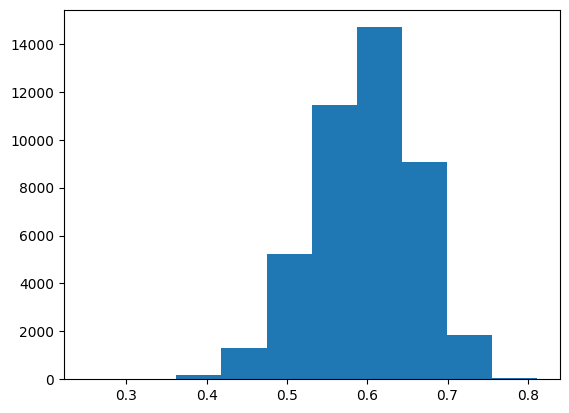

In [64]:
plt.hist(thresholds[1:])
plt.show()

In [78]:
thresholds = [np.inf]+[x for x in np.arange(0.0, 1.001, 0.001)]
perf = []

for i, threshold in enumerate(thresholds):
    pred_labels = (np.array(mean_scores)>=threshold).astype(int)
    tmp = compute_metric(valid_labels, pred_labels)
    tmp['Threshold'] = threshold
    perf.append(tmp)

tmp = pd.DataFrame(perf)
print(tmp.shape)
display(tmp.head())

tmp[tmp.accuracy == tmp.accuracy.max()]
tmp.sort_values('FPR', ascending=True, inplace=True)
sklearn.metrics.auc(tmp.FPR, tmp.TPR)

(1002, 8)


,accuracy,f1,precision,recall,TNR,FPR,TPR,Threshold
0,0.501469,0.333986,0.250735,0.5,1.0,0.0,0.0,inf
1,0.498531,0.332680,0.249265,0.5,0.0,1.0,1.0,0.000
2,0.498531,0.332680,0.249265,0.5,0.0,1.0,1.0,0.001
3,0.498531,0.332680,0.249265,0.5,0.0,1.0,1.0,0.002
4,0.498531,0.332680,0.249265,0.5,0.0,1.0,1.0,0.003


0.6860951958025856

In [49]:
auc = sklearn.metrics.roc_auc_score(valid_labels, mean_scores)
auc

0.6861094559124378

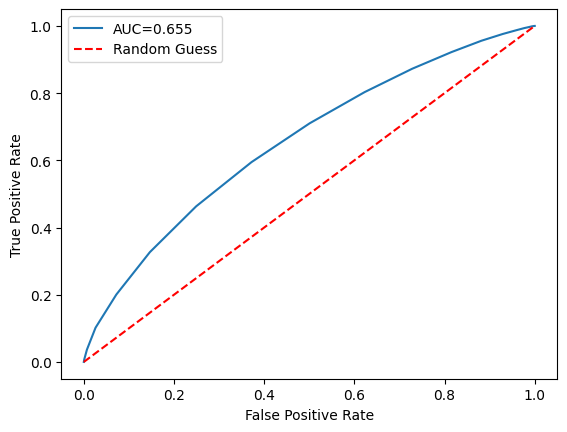

In [4]:
auc = sklearn.metrics.roc_auc_score(valid_labels, mean_scores)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [77]:
thresholds = [np.inf]+[x for x in np.arange(0.0, 1.001, 0.001)]
len(thresholds)

1002

In [86]:
result = []
for p in ['mpra_data', 'cao2021/ratios/hek', 'cao2021/ratios/hek_muscle', 
              'cao2021/ratios/hek_muscle_pc3', 'cao2021/ratios/hek_pc3', 'cao2021/ratios/muscle', 
              'cao2021/ratios/muscle_pc3', 'cao2021/ratios/pc3']:
    
    print(f"For test data [{p}]...")
    test_data = pd.read_csv(os.path.join(data_folder, p, 'test.csv'), delimiter=',', skiprows=1, header=None)
    if test_data.shape[1] == 2:
        labels = test_data[1].values.flatten()
    elif test_data.shape[1] > 2:
        labels = test_data[2].values.flatten()
    
    del [test_data]

    test_on = p.split('/')[-1]
    res = {'test_on':test_on}

    df = None
    cols = []
    for mName in ['DNABERT2', 'UTRLM', 'GROVER']:
        #perf[tr][mName]={}

        pred_data = pd.read_csv(os.path.join(pred_folder, f"{mName}_test_{test_on}_results_sep.csv"))
        pred_data.drop(columns=['cao2021'], inplace=True)

        cname = [col for col in pred_data.columns if 'proba' in col]
        pred_data = pred_data[cname]

        for col in pred_data.columns:
            cols.append(f"{mName}_{col}")
            #pred_data[col] = pred_data[col].astype(int)

        #print(mName, pred_data.shape)
        #display(pred_data.head())

        if df is None:
            df = pd.DataFrame(pred_data)
        else:
            df = pd.concat([df, pred_data], ignore_index=True, axis=1)

        del [pred_data]

    df.columns = cols
    valid_labels = labels if df.shape[0]==len(labels) else labels[1:]
    mean_scores = df.mean(axis=1).values.tolist()
    #tpr, fpr, thresholds, mean_scores = compute_threshold_pred(df, valid_labels)
    #del [df]

    res['model']='THRESHOLD'

    thresholds = [np.inf]+[x for x in np.arange(0.0, 1.001, 0.001)]
    perf = []

    for i, threshold in enumerate(thresholds):
        pred_labels = (np.array(mean_scores)>=threshold).astype(int)
        tmp = compute_metric(valid_labels, pred_labels)
        tmp['Threshold'] = threshold
        perf.append(tmp)

    df_perf = pd.DataFrame(perf)

    auc = sklearn.metrics.roc_auc_score(valid_labels, mean_scores)
    res['auc']=auc

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10),)
    plt.suptitle(f'Analysis on test data of {test_on}')
    #plt.Figure(figsize=(20,10))

    ax[0][0].plot(fpr, tpr, label=f"AUC={auc:.3f}")
    ax[0][0].plot([0, 1], [0, 1], 'r--', label='Random Guess')
    ax[0][0].set_xlabel('False positive rate')
    ax[0][0].set_ylabel('True positive rate')
    ax[0][0].set_title('AUC')
    ax[0][0].legend()
    #plt.show()

    #plt.Figure(figsize=(20,10))
    maxy = df_perf.accuracy.max()
    res['accuracy']=maxy
    maxx = df_perf.Threshold[df_perf.accuracy==maxy].values[0]
    s = f"Accuracy={maxy:.3f} at threshold={maxx:.2f}"
    ax[0][1].plot(df_perf.Threshold, df_perf.accuracy)
    ax[0][1].set_xlabel('Thresholds')
    ax[0][1].set_ylabel('Accuracy')
    ax[0][1].set_title('Accuracy')
    ax[0][1].axvline(x=maxx, color='r', linestyle='--', label=s)
    ax[0][1].legend()
    #plt.show()

    #plt.Figure(figsize=(20,10))
    maxy = df_perf.f1.max()
    res['f1']=maxy
    maxx = df_perf.Threshold[df_perf.f1==maxy].values[0]
    s = f"F1={maxy:.3f} at threshold={maxx:.2f}"
    ax[0][2].plot(df_perf.Threshold, df_perf.f1)
    ax[0][2].set_xlabel('Thresholds')
    ax[0][2].set_ylabel('F1 score')
    ax[0][2].set_title('F1 score')
    ax[0][2].axvline(x=maxx, color='r', linestyle='--', label=s)
    ax[0][2].legend()
    #plt.show()

    #plt.Figure(figsize=(20,10))
    maxy = df_perf.precision.max()
    res['precision']=maxy
    maxx = df_perf.Threshold[df_perf.precision==maxy].values[0]
    s = f"Precision={maxy:.3f} at threshold={maxx:.2f}"
    ax[1][0].plot(df_perf.Threshold, df_perf.precision)
    ax[1][0].set_xlabel('Threshold')
    ax[1][0].set_ylabel('Precision')
    ax[1][0].set_title('Precision')
    ax[1][0].axvline(x=maxx, color='r', linestyle='--', label=s)
    ax[1][0].legend()
    #plt.show()

    #plt.Figure(figsize=(20,10))
    maxy = df_perf.recall.max()
    res['recall']=maxy
    maxx = df_perf.Threshold[df_perf.recall==maxy].values[0]
    s = f"Sensitivity={maxy:.3f} at threshold={maxx:.2f}"
    ax[1][1].plot(df_perf.Threshold, df_perf.recall)
    ax[1][1].set_xlabel('Threshold')
    ax[1][1].set_ylabel('Sensitivity')
    ax[1][1].set_title('Sensitivity')
    ax[1][1].axvline(x=maxx, color='r', linestyle='--', label=s)
    ax[1][1].legend()
    #plt.show()

    #plt.Figure(figsize=(20,10))
    maxy = df_perf.TNR.max()
    maxx = df_perf.Threshold[df_perf.TNR==maxy].min()
    if maxx == np.inf:
        maxx = df_perf.Threshold[df_perf.Threshold<maxx].max()
        maxy = df_perf.TNR[df_perf.Threshold==maxx].values[0]
    res['TNR']=maxy

    s = f"Specificity={maxy:.3f} at threshold={maxx:.2f}"

    ax[1][2].plot(df_perf.Threshold, df_perf.TNR)
    ax[1][2].set_xlabel('Threshold')
    ax[1][2].set_ylabel('Specificity')
    ax[1][2].set_title('Specificity')
    ax[1][2].axvline(x=maxx, color='r', linestyle='--', label=s)
    ax[1][2].legend()

    result.append(res)

    plt.savefig(f'Figure/perf_analysis/{test_on}_sep.pdf', format='pdf')
    plt.close()
    #plt.show()
    #break

For test data [mpra_data]...
For test data [cao2021/ratios/hek]...
For test data [cao2021/ratios/hek_muscle]...
For test data [cao2021/ratios/hek_muscle_pc3]...
For test data [cao2021/ratios/hek_pc3]...
For test data [cao2021/ratios/muscle]...
For test data [cao2021/ratios/muscle_pc3]...
For test data [cao2021/ratios/pc3]...


In [90]:
df_perf = pd.DataFrame(result)
df_perf = df_perf[['model', 'test_on', 'accuracy', 'f1', 'precision', 'recall', 'TNR', 'auc']]
print(df_perf.shape)
df_perf.to_csv(os.path.join('../Data/', "threshold_perf_sep.csv"), index=False)
df_perf


(8, 8)


,model,test_on,accuracy,f1,precision,recall,TNR,auc
0,THRESHOLD,mpra_data,0.634294,0.634200,0.750758,0.634252,1.0,0.686109
1,THRESHOLD,hek,0.706796,0.706791,0.751870,0.706796,1.0,0.775478
2,THRESHOLD,hek_muscle,0.731079,0.730727,0.757615,0.730648,1.0,0.808017
3,THRESHOLD,hek_muscle_pc3,0.743352,0.742850,0.753998,0.742850,1.0,0.814566
4,THRESHOLD,hek_pc3,0.730640,0.730555,0.754697,0.730590,1.0,0.806439
5,THRESHOLD,muscle,0.621918,0.621574,0.756338,0.621840,1.0,0.636432
6,THRESHOLD,muscle_pc3,0.758674,0.757813,0.774640,0.757855,1.0,0.838849
7,THRESHOLD,pc3,0.708574,0.708452,0.754408,0.708574,1.0,0.783033


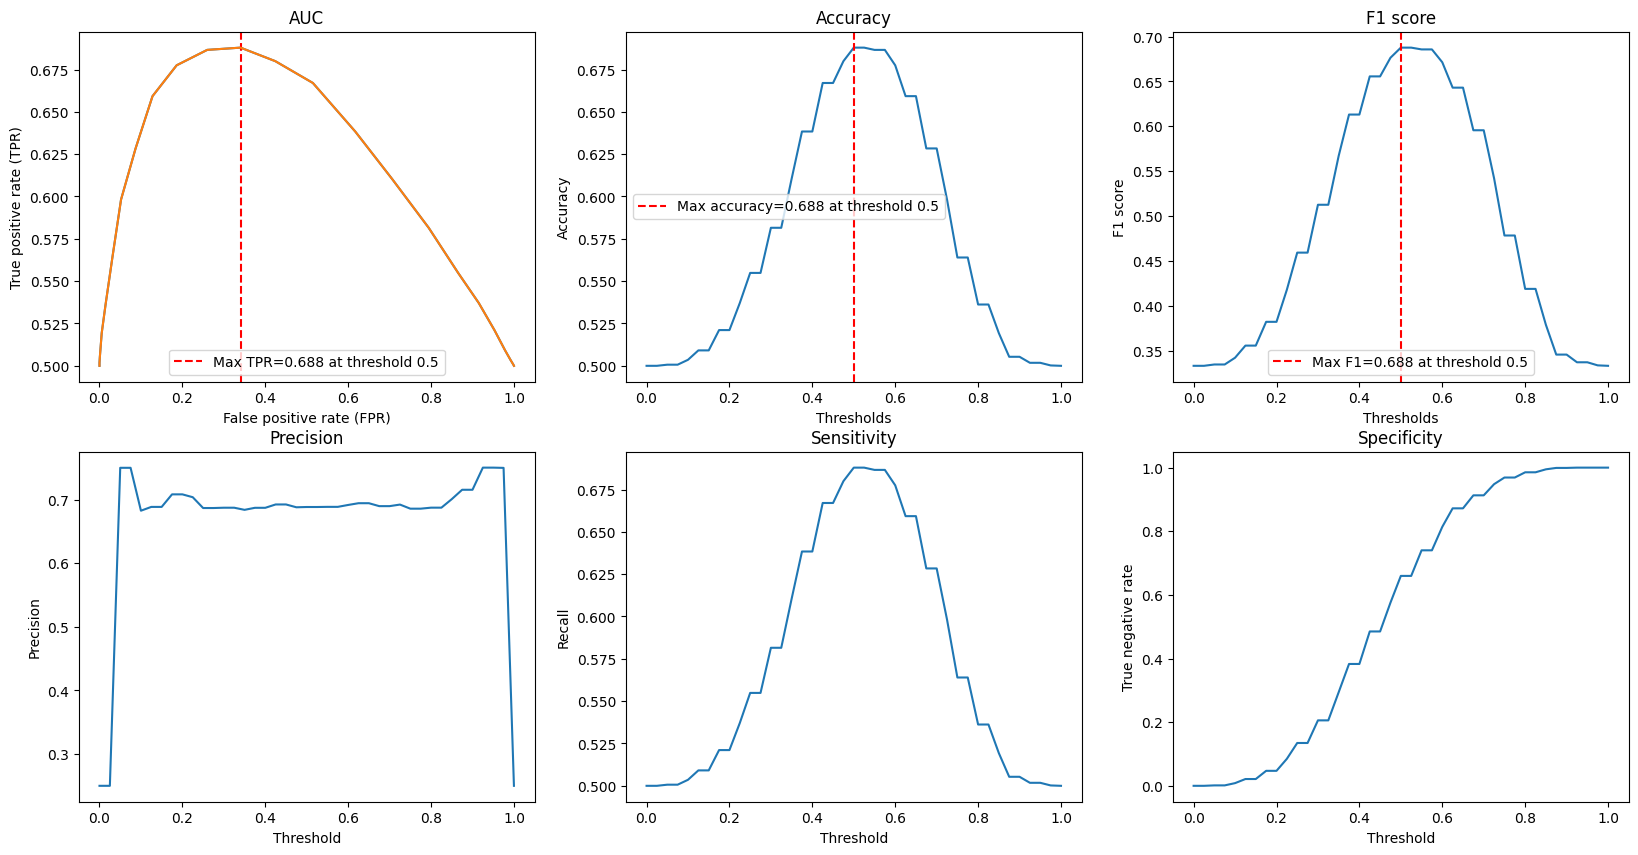

In [69]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10),)
plt.suptitle('')
#plt.Figure(figsize=(20,10))
maxy = df_perf.recall.max()
maxx = df_perf.FPR[df_perf.recall==maxy].values[0]
max_th = df_perf.Threshold[df_perf.recall==maxy].values[0]
ax[0][0].plot(df_perf.FPR, df_perf.recall)
ax[0][0].set_xlabel('False positive rate (FPR)')
ax[0][0].set_ylabel('True positive rate (TPR)')
ax[0][0].set_title('AUC')
ax[0][0].axvline(x=maxx, color='r', linestyle='--', label=f'Max TPR={maxy:.3f} at threshold {max_th}')
ax[0][0].legend()
#plt.show()

#plt.Figure(figsize=(20,10))
maxy = df_perf.accuracy.max()
max_th = df_perf.Threshold[df_perf.accuracy==maxy].values[0]
ax[0][0].plot(df_perf.FPR, df_perf.recall)
ax[0][1].plot(df_perf.Threshold, df_perf.accuracy)
ax[0][1].set_xlabel('Thresholds')
ax[0][1].set_ylabel('Accuracy')
ax[0][1].set_title('Accuracy')
ax[0][1].axvline(x=max_th, color='r', linestyle='--', label=f'Max accuracy={maxy:.3f} at threshold {max_th}')
ax[0][1].legend()
#plt.show()

#plt.Figure(figsize=(20,10))
maxy = df_perf.f1.max()
max_th = df_perf.Threshold[df_perf.f1==maxy].values[0]
ax[0][2].plot(df_perf.Threshold, df_perf.f1)
ax[0][2].set_xlabel('Thresholds')
ax[0][2].set_ylabel('F1 score')
ax[0][2].set_title('F1 score')
ax[0][2].axvline(x=max_th, color='r', linestyle='--', label=f'Max F1={maxy:.3f} at threshold {max_th}')
ax[0][2].legend()
#plt.show()

#plt.Figure(figsize=(20,10))
ax[1][0].plot(df_perf.Threshold, df_perf.precision)
ax[1][0].set_xlabel('Threshold')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision')
#plt.show()

#plt.Figure(figsize=(20,10))
ax[1][1].plot(df_perf.Threshold, df_perf.recall)
ax[1][1].set_xlabel('Threshold')
ax[1][1].set_ylabel('Recall')
ax[1][1].set_title('Sensitivity')
#plt.show()

#plt.Figure(figsize=(20,10))
ax[1][2].plot(df_perf.Threshold, df_perf.TNR)
ax[1][2].set_xlabel('Threshold')
ax[1][2].set_ylabel('True negative rate')
ax[1][2].set_title('Specificity')

plt.show()

## Create data for blend

In [106]:
perf = []
for p in ['mpra_data', 'cao2021/ratios/hek', 'cao2021/ratios/hek_muscle', 
              'cao2021/ratios/hek_muscle_pc3', 'cao2021/ratios/hek_pc3', 'cao2021/ratios/muscle', 
              'cao2021/ratios/muscle_pc3', 'cao2021/ratios/pc3']:
    
    print(f"For test data [{p}]...")
    test_data = pd.read_csv(os.path.join(data_folder, p, 'test.csv'), delimiter=',', skiprows=1, header=None)
    if test_data.shape[1] == 2:
        labels = test_data[1].values.flatten()
    elif test_data.shape[1] > 2:
        labels = test_data[2].values.flatten()
    
    del [test_data]

    test_on = p.split('/')[-1]

    df = None
    cols = []
    for mName in ['DNABERT2', 'UTRLM', 'GROVER']:
        #perf[tr][mName]={}

        pred_data = pd.read_csv(os.path.join(pred_folder, f"{mName}_test_{test_on}_results.csv"))
        pred_data.drop(columns=['cao2021'], inplace=True)

        for col in pred_data.columns:
            cols.append(f"{mName}_{col}")
            pred_data[col] = pred_data[col].astype(int)

        #print(mName, pred_data.shape)
        #display(pred_data.head())

        if df is None:
            df = pd.DataFrame(pred_data)
        else:
            df = pd.concat([df, pred_data], ignore_index=True, axis=1)

        del [pred_data]

    df.columns = cols
    valid_labels = labels if df.shape[0]==len(labels) else labels[1:]
    df[f'true_lable'] = valid_labels
    df.to_csv(os.path.join(f'../Data/Blend/{test_on}.csv'), index=False)
    del [df]

For test data [mpra_data]...
For test data [cao2021/ratios/hek]...
For test data [cao2021/ratios/hek_muscle]...
For test data [cao2021/ratios/hek_muscle_pc3]...
For test data [cao2021/ratios/hek_pc3]...
For test data [cao2021/ratios/muscle]...
For test data [cao2021/ratios/muscle_pc3]...
For test data [cao2021/ratios/pc3]...


In [58]:
pred_data.columns

Index(['mpra_data', 'hek', 'hek_muscle', 'hek_muscle_pc3', 'hek_pc3', 'muscle',
       'muscle_pc3', 'pc3', 'Major_vote'],
      dtype='object')

In [17]:
df = pd.DataFrame(perf)
print(df.shape)
df.sort_values(['test_on', 'model', 'train_on'], ascending=[True, True, True], inplace=True)
#df.to_csv('../Data/model_perf.csv', index=False)
df.head(10)

(200, 8)


,model,train_on,test_on,accuracy,f1,matthews_correlation,precision,recall
26,DNABERT2,hek,hek,0.491899,0.483995,-0.016722,0.491899,0.491370
51,DNABERT2,hek_muscle,hek,0.515475,0.502108,0.023251,0.511101,0.512175
76,DNABERT2,hek_muscle_pc3,hek,0.501209,0.493979,0.006527,0.503157,0.503374
101,DNABERT2,hek_pc3,hek,0.501258,0.493129,-0.001240,0.499398,0.499362
1,DNABERT2,mpra_data,hek,0.498041,0.442515,-0.002657,0.498973,0.498282
126,DNABERT2,muscle,hek,0.501370,0.481761,0.004144,0.501907,0.502252
151,DNABERT2,muscle_pc3,hek,0.481367,0.468431,-0.033285,0.484286,0.482375
176,DNABERT2,pc3,hek,0.499112,0.489961,-0.001844,0.499112,0.499043
42,GROVER,hek,hek,0.773177,0.773159,0.546443,0.773177,0.773266
67,GROVER,hek_muscle,hek,0.872822,0.872769,0.745684,0.872980,0.872704


In [15]:
r = []
for p in ['mpra_data', 'cao2021/ratios/hek', 'cao2021/ratios/hek_muscle', 
              'cao2021/ratios/hek_muscle_pc3', 'cao2021/ratios/hek_pc3', 'cao2021/ratios/muscle', 
              'cao2021/ratios/muscle_pc3', 'cao2021/ratios/pc3']:
    
    tr_data = pd.read_csv(os.path.join(data_folder, p, 'train.csv'), delimiter=',', skiprows=1, header=None)
    val_data = pd.read_csv(os.path.join(data_folder, p, 'dev.csv'), delimiter=',', skiprows=1, header=None)
    ts_data = pd.read_csv(os.path.join(data_folder, p, 'test.csv'), delimiter=',', skiprows=1, header=None)

    d = p.split('/')[-1]

    r.append([d, tr_data.shape[0], val_data.shape[0], ts_data.shape[0]])

tmp = pd.DataFrame(r)
tmp.columns = ['Dataset', 'Train size', 'Validation size', 'Test size']
tmp.to_csv(os.path.join('../Data/', 'data_size.csv'), index=False)
tmp

,Dataset,Train size,Validation size,Test size
0,mpra_data,784194,98023,98024
1,hek,35549,4444,4444
2,hek_muscle,34617,4808,3846
3,hek_muscle_pc3,67025,9309,7447
4,hek_pc3,64403,8945,7155
5,muscle,2914,364,365
6,muscle_pc3,35031,4865,3892
7,pc3,36009,4501,4502
